Install Libraries

In [ ]:
pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr


In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from scipy.optimize import minimize
import warnings
from collections import OrderedDict
import datetime as dt
from sklearn.decomposition import PCA

Pick stocks and time period

In [4]:
ticks = ['TSLA','NVDA','AMZN','JNJ','AAPL','XOM','JPM','TGT','LMT','COST']
total_stocks = len(ticks)
start_date = '2016-01-01'
end_date = '2023-10-31'

# Training and Testing Periods
train_start_date = '2016-01-01'
train_end_date = '2022-01-01'

test_start_date = '2022-01-01'
test_end_date = '2023-10-31'

trading_days = 252

training_period = trading_days*5

portfolio_current_value = 2000000 # 2 Million USD

Fetch data from Yahoo Finance

In [5]:
price_data = pdr.get_data_yahoo(ticks,start=start_date,end=end_date)['Adj Close']

[*********************100%%**********************]  10 of 10 completed


Normalization of stock prices (Adjusted Close Price)

In [6]:
daily_returns = price_data.pct_change()
daily_returns.head()

,AAPL,AMZN,COST,JNJ,JPM,LMT,NVDA,TGT,TSLA,XOM
Date,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,-0.025059,-0.005024,0.002445,0.004180,0.001729,0.023685,0.016064,0.017539,0.000090,0.008521
2016-01-06,-0.019570,-0.001799,-0.009254,-0.005055,-0.014436,-0.002886,-0.041350,-0.010155,-0.019648,-0.008320
2016-01-07,-0.042205,-0.039058,-0.022909,-0.011655,-0.040440,-0.019942,-0.039645,-0.002700,-0.015477,-0.016006
2016-01-08,0.005288,-0.001464,-0.017504,-0.010683,-0.022399,-0.001782,-0.021466,-0.033838,-0.021563,-0.020202


Splitting data into Training(75%) and Testing Dataset (25%)

---



In [7]:
training_returns = daily_returns[daily_returns.index <= train_end_date]
testing_returns  = daily_returns[daily_returns.index > train_end_date]

print("training length:",len(training_returns),"testing length:",len(testing_returns))

training length: 1511 testing length: 459


Covariance matrix from training normalized returns

In [8]:
covariance_returns = training_returns.cov()

PCA with inbuilt libraries

In [9]:
pca = PCA()
pca.fit(covariance_returns)
factor_loading = pca.components_
print("The matrix of Eigen Vectors has the shape: %s"%str(factor_loading.shape))

eigen_vals = pca.explained_variance_
print("The eigen values of the matrix: %s"% str(eigen_vals))

The matrix of Eigen Vectors has the shape: (10, 10)
The eigen values of the matrix: [1.64572782e-07 4.39225995e-08 1.32084507e-08 7.92752110e-09
 3.83564960e-09 2.23461245e-09 1.52414227e-09 1.26570250e-09
 7.11227671e-10 5.73216771e-41]


In [10]:

def eigen_portfolio_inbuilt_libraries(eigen_prices):
  ereturn = eigen_prices.pct_change()
  ecov = ereturn.cov()
  epca = PCA()
  epca.fit(ecov)

  efactor_loadings = epca.components_

  eigen_values = epca.explained_variance_
  return OrderedDict(zip(ticks,efactor_loadings[0]/np.sum(efactor_loadings[0])))

PCA without using libraries for k = 10 Principal components

In [11]:
def mean_normalize(data):
    mean = np.mean(data, axis=0)
    normalized_data = data - mean
    return normalized_data, mean

def compute_covariance_matrix(data):
    num_samples = data.shape[0]
    covariance_matrix = np.dot(data.T, data) / (num_samples - 1)
    return covariance_matrix

def pca_without(data, num_components):
    # Step 1: Mean normalization
    normalized_data, mean = mean_normalize(data)

    # Step 2: Compute the covariance matrix
    covariance_matrix = compute_covariance_matrix(normalized_data)

    # Step 3: Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 4: Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    #Step 4.1 Corrections to limit number of components
    eigenvalues = eigenvalues[:num_components]
    eigenvectors = eigenvectors.T
    eigenvectors = eigenvectors[:num_components]
    # Calculate the variance captured by each principal component as a percentage of total variance

    variance_captured = np.sum(eigenvalues)

    return eigenvectors, eigenvalues, mean, variance_captured

In [12]:
def eigen_portfolio_without_libraries(prices):
  ereturn = prices.pct_change()

  ecov = ereturn.cov()

  eigenvectors,eigenvalues,  mean, variance_captured = pca_without(ecov, num_components=10)

  efactor_loadings = eigenvectors

  eigen_values = eigenvalues

  explained_variance = variance_captured

  return OrderedDict(zip(ticks,efactor_loadings[0]/np.sum(efactor_loadings[0])))

Minimum Variance Portfolio using Optimization

In [13]:
def min_variance_portfolio(prices):
  min_var_returns = prices.pct_change()
  cov_matrix = min_var_returns.cov()
  num_assets = len(cov_matrix)
  # Define the objective function to minimize (variance of the portfolio)
  def portfolio_variance(weights):
      return np.dot(weights, np.dot(cov_matrix, weights))

  def weight_cons(weights):
    return np.sum(weights)-1

  bounds_lim = [(0, 1) for x in range(len(min_var_returns.columns))] # change to (-1, 1) if you want to short
  init = [1/len(min_var_returns.columns) for i in range(len(min_var_returns.columns))]
  constraint = {'type': 'eq', 'fun': weight_cons}

  optimal = minimize(fun=portfolio_variance,
                       x0=init,
                       bounds=bounds_lim,
                       constraints=constraint,
                       method='SLSQP'
                       )

  return OrderedDict(zip(ticks,optimal['x']))


defining metrics Sharpe Ratio and YoY return

In [14]:
# Metrics - Portfolio Level
def sharpe_ratio(portfolio_returns):
  return portfolio_returns.mean()/portfolio_returns.std()*np.sqrt(trading_days)

def yoy_return(portfolio_returns):
  number_of_years = len(portfolio_returns.index.year.unique())
  return np.power((portfolio_returns+1).cumprod().iloc[-1],1/number_of_years)

Defining function to back test the performance of each strategy for selected time period

In [15]:
# Portfolio backtesting - Testing period with different strategies
def daily_portfolio_value(prices,alloc_func = eigen_portfolio_inbuilt_libraries):


  #Creating a dataframe with index for testing period
  daily_port_alloc = pd.DataFrame(index=prices.loc[test_start_date:].index,columns=prices.columns)
  #daily_port_variance = pd.DataFrame(index=prices.loc[test_start_date:].index,columns='variance')


  #identify the first day of each unique month in daily_port_alloc's index and store those days in rebalance_days for the testing period
  rebalance_days = daily_port_alloc[~daily_port_alloc.index.to_period('m').duplicated()].index


  #Create a dataframe with only rebalance days so that updates weights are added later on
  port_alloc_weights = pd.DataFrame(index =rebalance_days,columns=prices.columns)

  #portfolio_variance = pd.DataFrame(index =rebalance_days,columns='Variance')

  current_portfolio_current_value = portfolio_current_value # 2 million USD

  share_allocation = None #default

  #print(rebalance_days[2]-dt.timedelta(days=training_period))

  for day in rebalance_days:

    if share_allocation is not None:
       current_portfolio_current_value = (prices.loc[day]*share_allocation).sum()

    allocation = alloc_func(prices[day-dt.timedelta(days=training_period):day])   #Taking 1511 Days prior to rebalance day for each month
    #print(type(allocation))


    #portfolio_variance.loc[day] = captured_variance

    port_alloc_weights.loc[day] = allocation #Adding weights calculated in the prior step according to the strategy utilized

    share_allocation = (pd.Series(allocation)*current_portfolio_current_value)/prices.loc[day] #multiplying weights to get the actual amount invested

    daily_port_alloc.loc[day] = share_allocation # assigning the values to rebalancing days



  daily_port_alloc = (daily_port_alloc.ffill()).dropna() #applying same share allocation to the whole period
  #daily_port_variance = (daily_port_alloc.ffill()).dropna()

  #print(portfolio_variance)

  portfolio_each_asset_daily_val = prices.loc[daily_port_alloc.index]*daily_port_alloc

  portfolio_daily_val = (portfolio_each_asset_daily_val).sum(axis=1)

  portfolio_daily_return = portfolio_daily_val.pct_change()

  return {
      'sharpe': sharpe_ratio(portfolio_daily_return),
      'yearly_ret': yoy_return(portfolio_daily_return),
      'portfolio_vals':portfolio_daily_val,
      'portfolio_each_asset_daily_val':portfolio_each_asset_daily_val

  }

  return portfolio_daily_val

Creating a dictionary to tabulate various strategies and storing the results similarly

In [16]:
strategy_list = {'min_variance_portfolio': min_variance_portfolio,
                 'eigen_portfolio_without_libraries k = 10 ':eigen_portfolio_without_libraries,
                 'eignen_portfolio_inbuilt k = 10 ':eigen_portfolio_inbuilt_libraries,
                 }


strategy_results = { key: daily_portfolio_value(price_data,func) for key,func in strategy_list.items()}
res = pd.DataFrame(strategy_results).T

In [17]:
return_frame = pd.DataFrame(index=res['portfolio_vals']['min_variance_portfolio'].index)
for key in res['portfolio_vals'].keys():

  return_frame[key] =res['portfolio_vals'][key]

Portfolio Value for each strategy : x axis - time period. y axis - value in Millions USD

<Axes: xlabel='Date'>

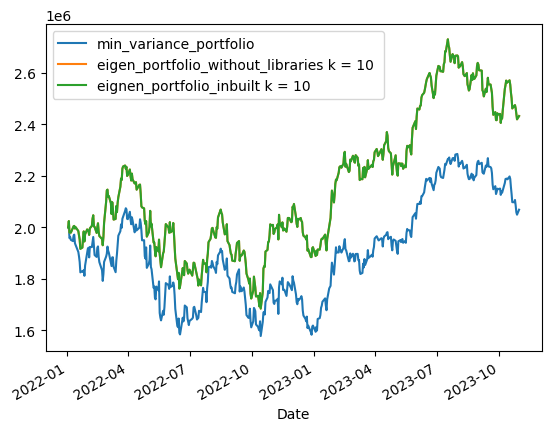

In [18]:
return_frame.plot()

Final Result

In [19]:
res[['sharpe','yearly_ret']]

,sharpe,yearly_ret
min_variance_portfolio,0.196091,1.016992
eigen_portfolio_without_libraries k = 10,0.593968,1.102808
eignen_portfolio_inbuilt k = 10,0.593968,1.102808


Finding top 5 influencing stocks

<Axes: xlabel='Date'>

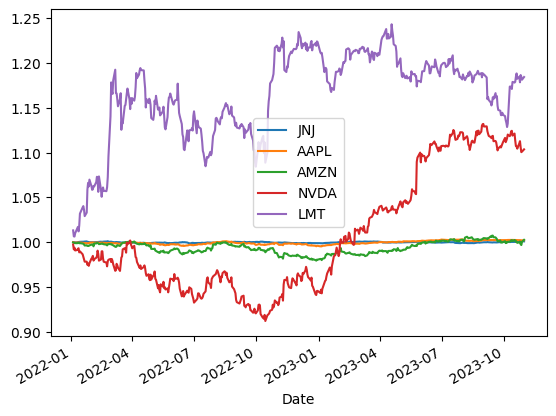

In [21]:
df = res.loc['eigen_portfolio_without_libraries k = 10 ']['portfolio_each_asset_daily_val']
df.iloc[-1].sum()/df.iloc[0].sum()

#attribution for top 5 winners
ret_attr = (price_data.loc[df.index].pct_change()*(df.div(df.sum(axis=1),axis=0)).shift(1)+1).cumprod()
top_five = ret_attr.iloc[-1].sort_values().iloc[-5:].index
ret_attr[top_five].plot()